# Robust Design

Robust design optimization considers the average performance of a system with random design variables or parameters. The optimization aims to produce a robust design i.e., a design with performance that is less sensitive to inherent variability of the design variables and parameters of the system. Possible objective functions for the optimization could be the mean and standard deviation of the objective function. Minimizing the mean is usually the preferred formulation as although low variability may be desired, minimizing the standard deviation of the objective offers no incentive to the optimizer to improve the mean performance of the system. Another possible formulation is to use multiobjective optimization to find the tradeoff between minimizing the mean and standard deviation of the objective function or even using a linear combination of the two quantities as the objective of the optimization.  

To illustrate the implementation of robust design the following unconstrained optimization problem will be used,

$$
    f(x) = e^{x/2} + 0.2x^6 - 0.2x^5 - 0.75x^4 + x^2
$$
$$-1.2 \leq x \leq 2.0$$

Robust design methodologies will be applied to this function and the results will be analyzed. The first block of code below imports some of the required packages.

In [1]:
from scipy.optimize import minimize
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

The block of code below defines the function for the optimization problem and plots the function within the given range. 

Text(0.5, 1.0, 'Function')

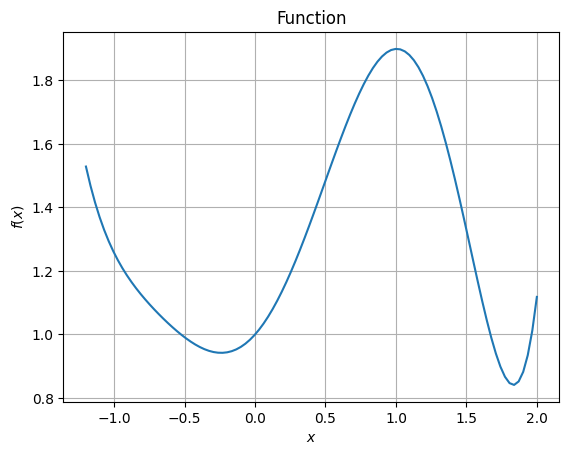

In [2]:
# Defining the function
function_1 = lambda x: np.exp(x/2) + 0.2*x**6 - 0.2*x**5 - 0.75*x**4 + x**2

# Bounds
x_lb = -1.2
x_ub = 2

# Number of plotting points
samples = 100

# Generating x points
x = np.linspace(x_lb, x_ub, samples)

# Computing function values at those x
f = function_1(x)

# Plotting
fig, ax = plt.subplots()
ax.plot(x,f)
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.grid()
ax.set_title("Function")

## Deterministic Optimization

Initially, let us assume that the design variable of the problem is deterministic and find the global minimum of the function. BFGS will be used for optimization here. Since there are two local minima, the final answer of the deterministic optimization will depend on starting point. The below block of code performs the optimization.

In [3]:
# Optimization settings
x0 = 1.2
method = "BFGS"
jac = "2-point"
options = {
    "disp": True
}

# Optimizing the function - Deterministic
result = minimize(function_1, method=method, jac=jac, x0=x0, options=options)

# Printing the results
print("Optimum: {}".format(result.fun))
print("Optimum obtained at: {}".format(result.x))

Optimization terminated successfully.
         Current function value: 0.841127
         Iterations: 4
         Function evaluations: 16
         Gradient evaluations: 8
Optimum: 0.8411270325019435
Optimum obtained at: [1.83413727]


Therefore, the deterministic global minimum of the problem is: $f^* = 0.8411$ at $x^* = 1.834$.

### Plotting stochastic function output

Now, let $x$ be a *normal distribution with $\sigma = 0.2$*, this will make $f(x)$ also stochastic. The block of code below plots the variation of mean and standard deviation of the function $f$ with respect to $x$. It also plots the combined variation. You can change the weight and see how the combined objective changes.

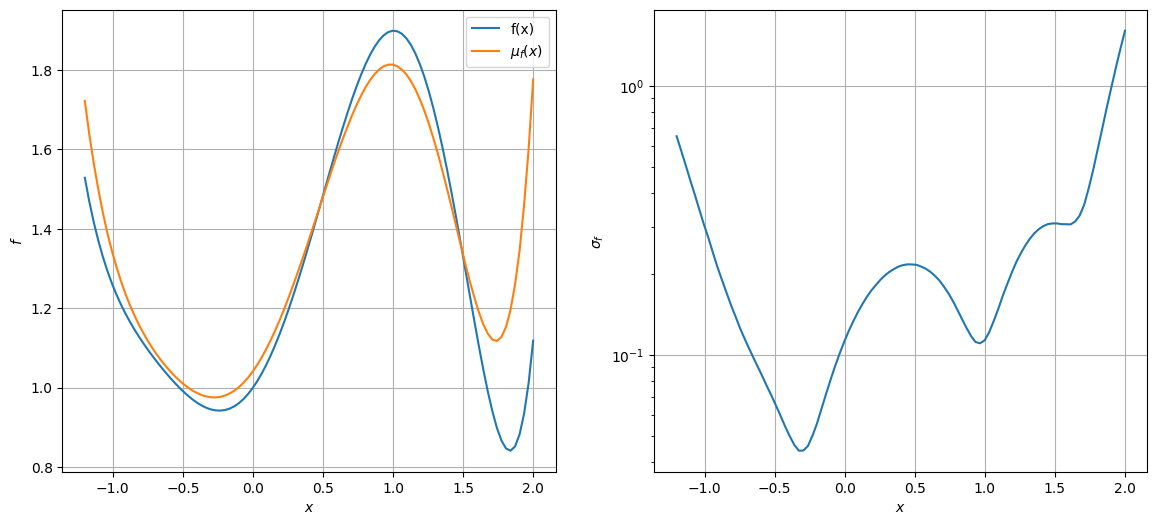

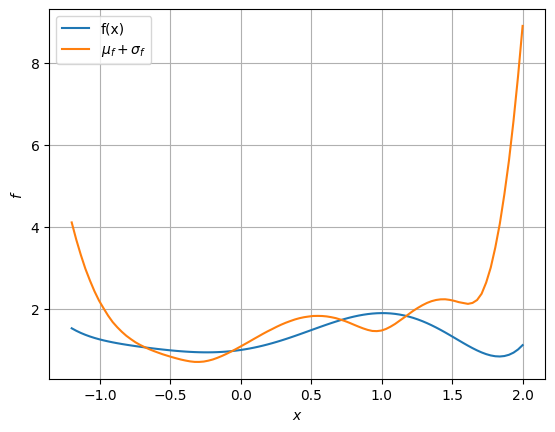

In [4]:
# Few parameters
sigma = 0.2
mcs_itr = 500000

# Initializing arrays
f_mean = np.zeros(samples)
f_sigma = np.zeros(samples)

# Performing mcs to compute mean and sigma
for i in range(samples):
    
    # Define normal random variable at given x
    rv = norm(loc=x[i], scale=sigma)
    
    # Compute function values at randomly generated inputs
    F = function_1(rv.rvs(mcs_itr))
    
    # Compute mean and standard deviation of f
    f_mean[i] = np.mean(F)
    f_sigma[i] = np.std(F)

# Plotting mean and standard deviation of function
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].plot(x,f,label="f(x)")
ax[0].plot(x,f_mean,label="$\mu_f(x)$")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f$")
ax[0].grid()
ax[0].legend()

ax[1].plot(x,f_sigma)
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$\sigma_f$")
ax[1].grid()
ax[1].set_yscale("log")

# Plotting combined mean and standard deviation
# std is multiplied by 10 for scaling
# w - weight
w = 0.5

fig, ax = plt.subplots()
ax.plot(x,f,label="f(x)")
ax.plot(x, w*f_mean + (1-w)*10*f_sigma,label="$\mu_f + \sigma_f$")
ax.set_xlabel("$x$")
ax.set_ylabel("$f$")
ax.grid()
ax.legend()

## Minimizing $\mu_f$

Firstly, $\mu_f$ is used as the objective. So, optimization problem statement is

$$
    \min_{x} \mu_f(x)
$$

Based on the variation of $\mu_f$, the global minimum appears to be at a different $x$ and will depend on the starting point. The block of code below defines the function for computing $\mu_f$. At any given $x$, MCS is performed to compute the mean of $f$.

In [5]:
# Few parameters
sigma = 0.2
mcs_itr = 500000

# Objective function
def robust_obj_mean(x):
    
    # Create a random variable located at the given x
    rv = norm(loc=x, scale=sigma)
    
    # Compute function value at various randomly generated points
    F = function_1(rv.rvs(mcs_itr))
    
    return np.mean(F)

Since MCS is performed for each input $x$ in the above function, there is some randomness involved which makes gradient computation harder. To optimize $\mu_f$, differential evolution is used since it doesn't rely on gradients. Since `pymoo` will be used, the relevant packages will be imported in the next code block.

In [6]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

# Defining a generic differential evolution problem
class RobustDesign(ElementwiseProblem):

    def __init__(self, function):
        super().__init__(n_var=1, n_obj=1, n_constr=0, xl=np.array([-1.2]), xu=np.array([2]))
        self.function = function

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = self.function(x)

problem = RobustDesign(function=robust_obj_mean)

algorithm = DE(pop_size=20, CR=0.8, dither="vector")

In [7]:
termination = DefaultSingleObjectiveTermination(
    xtol=1e-6,
    cvtol=1e-6,
    ftol=1e-6,
    period=10,
    n_max_gen=1000,
    n_max_evals=100000
)

res = minimize(problem, algorithm, termination=termination, verbose=False, 
               save_history=True)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Best solution found: 
X = [-0.28126161]
F = [0.97519447]


The minimum obtained from this stochastic optimization is $0.975$ at $x = -0.278$. Also, this optimum is different from the deterministic optimization.

### Minimizing $\sigma_f$

Now, let the objective be $\sigma_f$. So, optimization problem statement will be

$$
    \min_{x} \sigma_f(x)
$$

The block of code below defines the robust objective which computes the standard deviation of $f$.

In [8]:
# Few parameters
sigma = 0.2
mcs_itr = 500000

# Objective function
def robust_obj_sigma(x):
    
    # Create random located at the given x
    rv = norm(loc=x, scale=sigma)
    
    # Compute function value at various randomly generated points
    f = function_1(rv.rvs(mcs_itr))
    
    return np.std(f)

To optimize $\sigma_f$, differential evolution is used for the reason explained earlier. The optimization is performed in the following code block.

In [9]:
problem = RobustDesign(function=robust_obj_sigma)

res = minimize(problem, algorithm, termination=termination, verbose=False, 
               save_history=True)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
print("Mean function value at optimum: {}".format(robust_obj_mean(res.X)))

Best solution found: 
X = [-0.30179105]
F = [0.04368645]
Mean function value at optimum: 0.9760152775929745


The optimum obtained in this case only minimizes the standard deviation of $f$ with respect to the uncertainty in $x$ but doesn't necessarily minimize the mean value of the function itself.

## Minimizing both $\mu_f$ and $\sigma_f$

Now, let the objective be $w\mu_f + (1-w)10\sigma_f$. Here, $w$ is the weight given to both the objectives and $10$ is the scaling factor for $\sigma_f$. So, optimization problem statement will be

$$
    \min_{x} w\mu_f + (1-w)10\sigma_f
$$

The block of code below defines the robust objective which computes the standard deviation of $f$.

In [10]:
# Few parameters
sigma = 0.2
mcs_itr = 500000
weight = 0.5

# Objective function
def robust_obj_combined(x):
    
    # Create a random variable located at the given x
    rv = norm(loc=x, scale=sigma)
    
    # Compute function value at various randomly generated points
    f = function_1(rv.rvs(mcs_itr))
    
    return weight*np.mean(f) + weight*10*np.std(f)

To optimize combined objective, differential evolution is used for the reason explained earlier. Here, the weight parameter $w$ is kept as $0.5$ to give roughly equal weights to the mean and standard deviation. You can change the value of the weight and see how the optimum changes.

In [11]:
problem = RobustDesign(function=robust_obj_combined)

res = minimize(problem, algorithm, termination=termination, verbose=False, 
               save_history=True)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
print("Mean function value at optimum: {}".format(robust_obj_mean(res.X)))

Best solution found: 
X = [-0.30445152]
F = [0.70650679]
Mean function value at optimum: 0.9760742817931409
